In [1]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(dplyr)
library(patchwork)
library(BiocParallel)
setwd('/lustre/scratch117/cellgen/team297/kt16/Ziad/scanpy')

Loading required package: edgeR

Loading required package: limma

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedi

In [2]:
mylox1 <- readRDS('h5ad/R/milo_TNK_1.5.RDS')
mylox2 <- readRDS('h5ad/R/milo_TNK_2.5.RDS')

In [3]:
da.res_tnk1.5 <- readRDS(file = 'h5ad/R/model_1/milo_results_1.5vsuntreated_TNK.RDS')
da.res_tnk2.5 <- readRDS(file = 'h5ad/R/model_1/milo_results_2.5vsuntreated_TNK.RDS')

In [4]:
da.res_tnk1.5 <- annotateNhoods(mylox1, da.res_tnk1.5, coldata_col = "fine_clustering")
da.res_tnk1.5$fine_clustering <- ifelse(da.res_tnk1.5$fine_clustering_fraction < 0.7, "Mixed", da.res_tnk1.5$fine_clustering)
da.res_tnk2.5 <- annotateNhoods(mylox2, da.res_tnk2.5, coldata_col = "fine_clustering")
da.res_tnk2.5$fine_clustering <- ifelse(da.res_tnk2.5$fine_clustering_fraction < 0.7, "Mixed", da.res_tnk2.5$fine_clustering)

In [5]:
library(ggbeeswarm)
library(ggplot2)
new_DA_beeswarm_split <- function (da.res1, da.res2, max = 5, group.by = NULL, split.by =NULL, alpha = 0.1, subset.nhoods = NULL, size = 2) 
{
    da.res1$split = split.by[1]
    da.res2$split = split.by[2]
    da.res <- rbind(da.res1, da.res2)
    da.res$beta[da.res$beta > max] <- max
    da.res$beta[da.res$beta < -max] <- -max
    da.res <- da.res %>% filter(!fine_clustering %in% c('Mixed', 'doublets'))
    if (!is.null(group.by)) {
        if (!group.by %in% colnames(da.res)) {
            stop(paste0(group.by, " is not a column in da.res. Have you forgot to run annotateNhoods(x, da.res, ", 
                group.by, ")?"))
        }
        if (is.numeric(da.res[, group.by])) {
            stop(paste0(group.by, " is a numeric variable. Please bin to use for grouping."))
        }
        da.res <- mutate(da.res, group_by = da.res[, group.by])
    }
    else {
        da.res <- mutate(da.res, group_by = "g1")
    }    
    if (!is.factor(da.res[, "group_by"])) {
        message(paste0("Converting group.by to factor..."))
        da.res <- mutate(da.res, factor(group_by, levels = unique(group_by)))
    }
    if (!is.null(subset.nhoods)) {
        da.res <- da.res[subset.nhoods, ]
    }
        
    da.res <- da.res %>% mutate(is_signif = ifelse(SpatialFDR < alpha, 
        1, 0)) %>% mutate(beta_color = ifelse(is_signif == 1, 
        beta, NA)) %>% arrange(group_by) %>% mutate(Nhood = factor(Nhood, 
        levels = unique(Nhood)))
    p <- ggplot(da.res, aes(group_by, beta, color = beta_color)) + 
        scale_color_gradient2(midpoint = 0, low = "#0571b0", mid = '#f7f7f7', high = "#ca0020", limits=c(-max/3, max/3), oob=scales::squish) +
        guides(color = "none") + 
        xlab(group.by) + 
        ylab("beta") + 
        geom_quasirandom(alpha = 1, size = size) +
        coord_flip() + 
        theme_bw() + 
        theme(axis.title.y = element_blank(),
              axis.title.x = element_text(size=20, color = '#000000'),
              axis.text = element_text(size=20, color = '#000000'),
              axis.ticks = element_line(color = '#000000'),
              panel.border = element_rect(colour = "#000000")
            ) + 
        facet_wrap(split~.) +
        theme(strip.background = element_blank(), strip.text.x = element_text(angle = 0, size = 20, color = '#000000'))
    p$data <- p$data[order(p$data$beta_color, na.last = FALSE), ]
    return(p)
}

Converting group.by to factor...



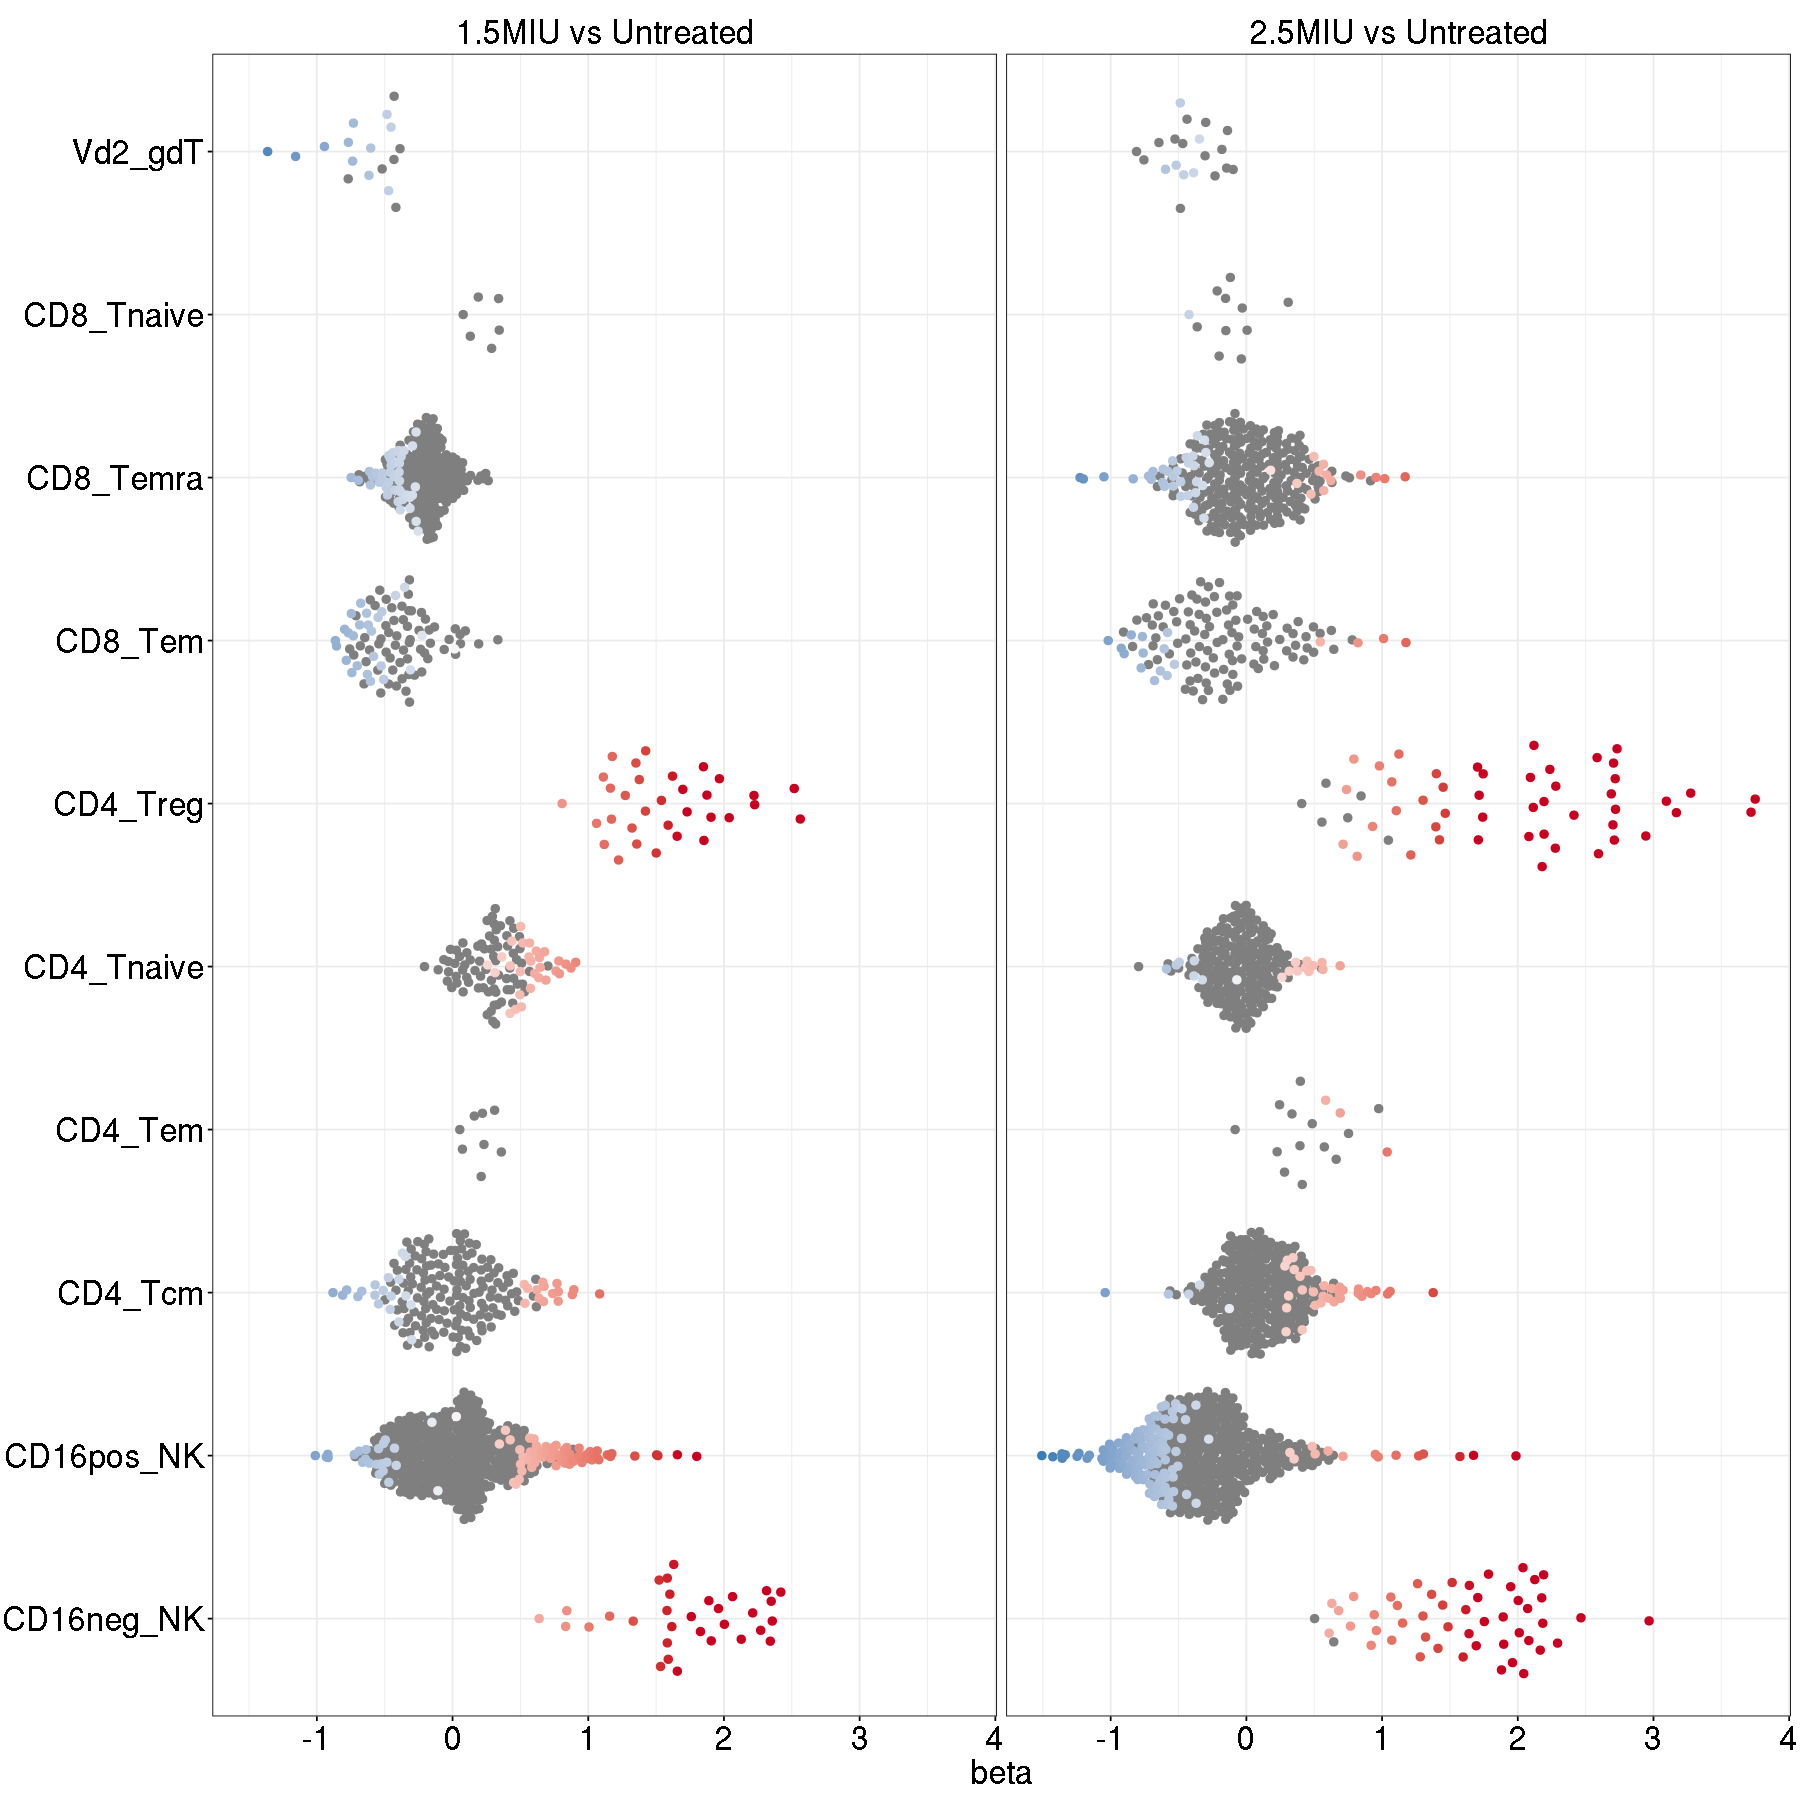

In [6]:
options(repr.plot.width=15, repr.plot.height=15)
p <- new_DA_beeswarm_split(da.res_tnk1.5, da.res_tnk2.5, group.by = "fine_clustering", split.by = c('1.5MIU vs Untreated', '2.5MIU vs Untreated'), size = 2)
p

In [7]:
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
cbind.fill <- function(...){
    nm <- list(...) 
    nm <- lapply(nm, as.matrix)
    n <- max(sapply(nm, nrow)) 
    do.call(cbind, lapply(nm, function (x) 
        rbind(x, matrix(, n-nrow(x), ncol(x))))) 
}

In [8]:
df1 = da.res_tnk1.5 %>% filter(fine_clustering == 'CD4_Treg' & SpatialFDR <.1 ) %>% select(beta)
df2 = da.res_tnk2.5 %>% filter(fine_clustering == 'CD4_Treg' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
1.3759630,1.7093526
1.5887381,1.4001882
1.6208977,1.4228327
0.8072809,2.7203778
1.6970325,0.9801675
1.6549602,2.5845627
1.7284693,1.2116424
1.8525259,2.7181396
2.2212968,3.7497219


In [9]:
df1 = da.res_tnk1.5 %>% filter(fine_clustering == 'CD4_Tcm' & SpatialFDR <.1) %>% select(beta)
df2 = da.res_tnk2.5 %>% filter(fine_clustering == 'CD4_Tcm' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
-0.3063686,0.5501249
-0.8097247,0.6459057
0.6218607,-0.3450084
-0.4733091,0.3114148
-0.3948789,0.4938961
0.5284037,0.5736952
0.7382052,0.5645138
-0.3479032,-0.1256780
-0.3006057,0.3956180


In [10]:
df1 = da.res_tnk1.5 %>% filter(fine_clustering == 'CD4_Tem' & SpatialFDR <.1) %>% select(beta)
df2 = da.res_tnk2.5 %>% filter(fine_clustering == 'CD4_Tem' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
NA,0.5844280
NA,1.0377234
NA,0.6915168


In [11]:
df1 = da.res_tnk1.5 %>% filter(fine_clustering == 'CD4_Tnaive' & SpatialFDR <.1) %>% select(beta)
df2 = da.res_tnk2.5 %>% filter(fine_clustering == 'CD4_Tnaive' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
0.3629915,0.46052307
0.3132348,-0.58854423
0.5075486,-0.38408555
0.7623846,-0.32503274
0.4960863,0.36312665
0.6880528,0.49188216
0.4989658,-0.38672236
0.5763186,0.43401929
0.5020038,0.26174348


In [12]:
df1 = da.res_tnk1.5 %>% filter(fine_clustering == 'CD8_Temra' & SpatialFDR <.1) %>% select(beta)
df2 = da.res_tnk2.5 %>% filter(fine_clustering == 'CD8_Temra' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
-0.2948377,0.5688909
-0.6126152,-0.6124463
-0.4280011,0.8428925
-0.4598135,0.5359782
-0.2682168,0.4978549
-0.3939344,-0.5434365
-0.4302525,-0.3856720
-0.2686642,-0.2741616
-0.2537780,0.4759239


In [13]:
df1 = da.res_tnk1.5 %>% filter(fine_clustering == 'CD16pos_NK' & SpatialFDR <.1) %>% select(beta)
df2 = da.res_tnk2.5 %>% filter(fine_clustering == 'CD16pos_NK' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
0.80466662,-0.7115625
0.76268848,-0.6249383
-0.42792618,-0.5997199
-0.51161704,-0.6176567
0.51085000,-0.6771280
0.38975339,0.9713338
0.86299807,-0.5366636
-0.50896948,-0.8169864
0.50114546,-0.7141930


In [14]:
df1 = da.res_tnk1.5 %>% filter(fine_clustering == 'CD16neg_NK' & SpatialFDR <.1) %>% select(beta)
df2 = da.res_tnk2.5 %>% filter(fine_clustering == 'CD16neg_NK' & SpatialFDR <.1) %>% select(beta)
as.data.frame(Map(cbind.fill, df1, df2, MoreArgs = list(fill=NA)))[,1:2]

beta.1,beta.2
<dbl>,<dbl>
0.8335814,2.4655783
1.5224692,1.5972737
1.1576009,1.2617083
1.3312345,1.6169652
2.0031117,2.0816432
0.6382107,2.1253731
2.2705823,1.7536130
1.7593727,0.7907382
2.4188182,1.7842446
